Load and parse the Dataset (Run this first!)

Update the directory which contains all xlsx files

In [1]:
import pandas as pd

from ParseData import parse_dataset
from utils.PropertyNames import ColumnNames as Cols

patient_data = parse_dataset("/home/meocakir/Documents/Datasets/Diabetes", silent=False)
patients = patient_data[Cols.patient].unique()

len(patient_data)

Opening file 1-P24 CGM modified date.xlsx:
Opening file 2-P19 CGM modified date.xlsx:
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 7, 10, 12), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 7, 10, 12), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 7, 14, 30), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 7, 14, 30), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 8, 14, 4), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 8, 14, 4), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 9, 13, 17), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 10, 14, 17), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 10, 14, 17), None, None, None)
Unable to parse row. Skipping... (datetime.datetime(2020, 10, 11, 8, 37), None, None, 

22291

Filter prune benchmark Test

In [2]:
from utils.PropertyNames import MethodOptions as Opts
from Benchmark import benchmark

params = {
    "k": 5,
    "risky_chars": {0, 1},
    "risk_threshold": 0.2,
    "prune": True,
    "prune_method": Opts.filter,
    "prune_threshold": 1,
    "weight_thresholds": [1, 3, 8],
    "value_ranges": [(0, 2), (2, 3), (3, float('inf'))],
    "max_steps": 6,
    "naive_threshold": 15
}

excluded = patients.copy().tolist()

#excluded.remove('P11')
#excluded.remove('P26')
benchmark(patient_data[patient_data[Cols.patient].isin(excluded)].copy(), start_time_range_hours=0,
          end_time_range_hours=1, **params)


Confusion matrix for Probabilistic_Alert


,Actual Positive,Actual Negative
Predicted Positive,700,1816
Predicted Negative,246,16547


Confusion matrix for Naive_Alert


,Actual Positive,Actual Negative
Predicted Positive,905,7487
Predicted Negative,41,10876


Confusion matrix for Combined_Alert_Or


,Actual Positive,Actual Negative
Predicted Positive,925,7831
Predicted Negative,21,10532


Confusion matrix for Combined_Alert_And


,Actual Positive,Actual Negative
Predicted Positive,680,1472
Predicted Negative,266,16891


,Alert Type,Accuracy,Balanced Accuracy,AUC-ROC,Precision,Sensitivity,Specificity,F1 Score
0,Probabilistic_Alert,0.89321,0.820532,0.820532,0.278219,0.739958,0.901105,0.404391
1,Naive_Alert,0.61013,0.774469,0.774469,0.107841,0.956660,0.592278,0.193832
2,Combined_Alert_Or,0.59335,0.775673,0.775673,0.105642,0.977801,0.573545,0.190682
3,Combined_Alert_And,0.90999,0.819327,0.819327,0.315985,0.718816,0.919839,0.438993


(            Alert Type  Accuracy  Balanced Accuracy   AUC-ROC  Precision  \
 0  Probabilistic_Alert   0.89321           0.820532  0.820532   0.278219   
 1          Naive_Alert   0.61013           0.774469  0.774469   0.107841   
 2    Combined_Alert_Or   0.59335           0.775673  0.775673   0.105642   
 3   Combined_Alert_And   0.90999           0.819327  0.819327   0.315985   
 
    Sensitivity  Specificity  F1 Score  
 0     0.739958     0.901105  0.404391  
 1     0.956660     0.592278  0.193832  
 2     0.977801     0.573545  0.190682  
 3     0.718816     0.919839  0.438993  ,
 {'Probabilistic_Alert': ([False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,

Adaptive prune benchmark Test

In [6]:
from utils.PropertyNames import MethodOptions as Opts
from Benchmark import benchmark

params = {
    "k": 6,
    "risky_chars": {0, 1},
    "risk_threshold": 0.2,
    "prune": True,
    "prune_method": Opts.adaptive,
    "prune_threshold": 1,
    "weight_thresholds": [1, 4, 10],
    "value_ranges": [(0, 2), (2, 3), (3, float('inf'))],
    "max_steps": 6,
    "naive_threshold": 15
}
excluded = patients.copy().tolist()

pd.set_option('display.float_format', '{:.4f}'.format)

_, _, result_df = benchmark(patient_data[patient_data[Cols.patient].isin(excluded)].copy(), start_time_range_hours=0,
          end_time_range_hours=1, **params)

Confusion matrix for Probabilistic_Alert


,Actual Positive,Actual Negative
Predicted Positive,770,2745
Predicted Negative,165,15469


Confusion matrix for Naive_Alert


,Actual Positive,Actual Negative
Predicted Positive,896,7427
Predicted Negative,39,10787


Confusion matrix for Combined_Alert_Or


,Actual Positive,Actual Negative
Predicted Positive,917,8122
Predicted Negative,18,10092


Confusion matrix for Combined_Alert_And


,Actual Positive,Actual Negative
Predicted Positive,749,2050
Predicted Negative,186,16164


,Alert Type,Accuracy,Balanced Accuracy,AUC-ROC,Precision,Sensitivity,Specificity,F1 Score
0,Probabilistic_Alert,0.8480,0.8364,0.8364,0.2191,0.8235,0.8493,0.3461
1,Naive_Alert,0.6101,0.7753,0.7753,0.1077,0.9583,0.5922,0.1936
2,Combined_Alert_Or,0.5749,0.7674,0.7674,0.1014,0.9807,0.5541,0.1839
3,Combined_Alert_And,0.8832,0.8443,0.8443,0.2676,0.8011,0.8874,0.4012


Adaptive prune benchmark Test on 2 patients

Plot Probability Distribution

Resulting graph: ProbabilityGraph with 805 nodes and 2293 edges


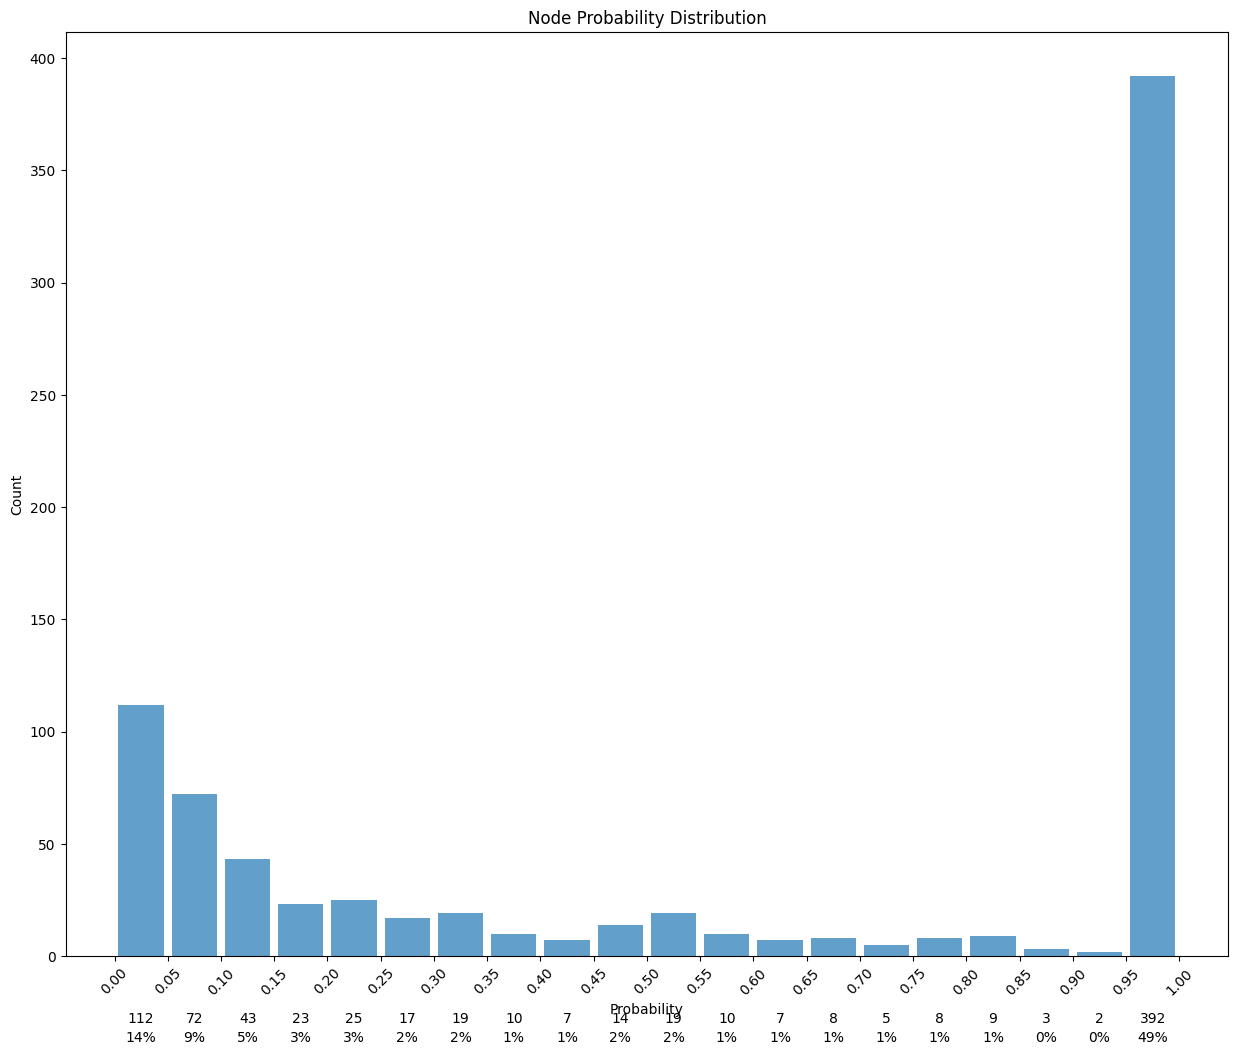

In [3]:
from utils.VisualizationUtils import draw_histogram
from deBruijn.ProbabilityGraph import ProbabilityGraph
from utils.PropertyNames import MethodOptions as Opts
from utils.PropertyNames import ColumnNames as Cols

k = 4
risky_chars: None
params = {
    "prune": False,
    "prune_method": Opts.filter,
    "prune_threshold": 3,
    "max_steps": 3,
}

sequences = []
for p in patients:
    float_seq = patient_data[patient_data[Cols.patient] == p]
    float_seq = float_seq.sort_values(Cols.date, ascending=True)[Cols.char]
    sequences.append(float_seq)

probability_graph = ProbabilityGraph(sequences=sequences, k=k)

print(f"Resulting graph: {probability_graph}")

probability_model = probability_graph.get_probability_model(**params)

draw_histogram(list(probability_model.probability_dict.values()), "Node Probability Distribution", "Probability",
               "Count", bins=20)


Draw timeline of one of our models

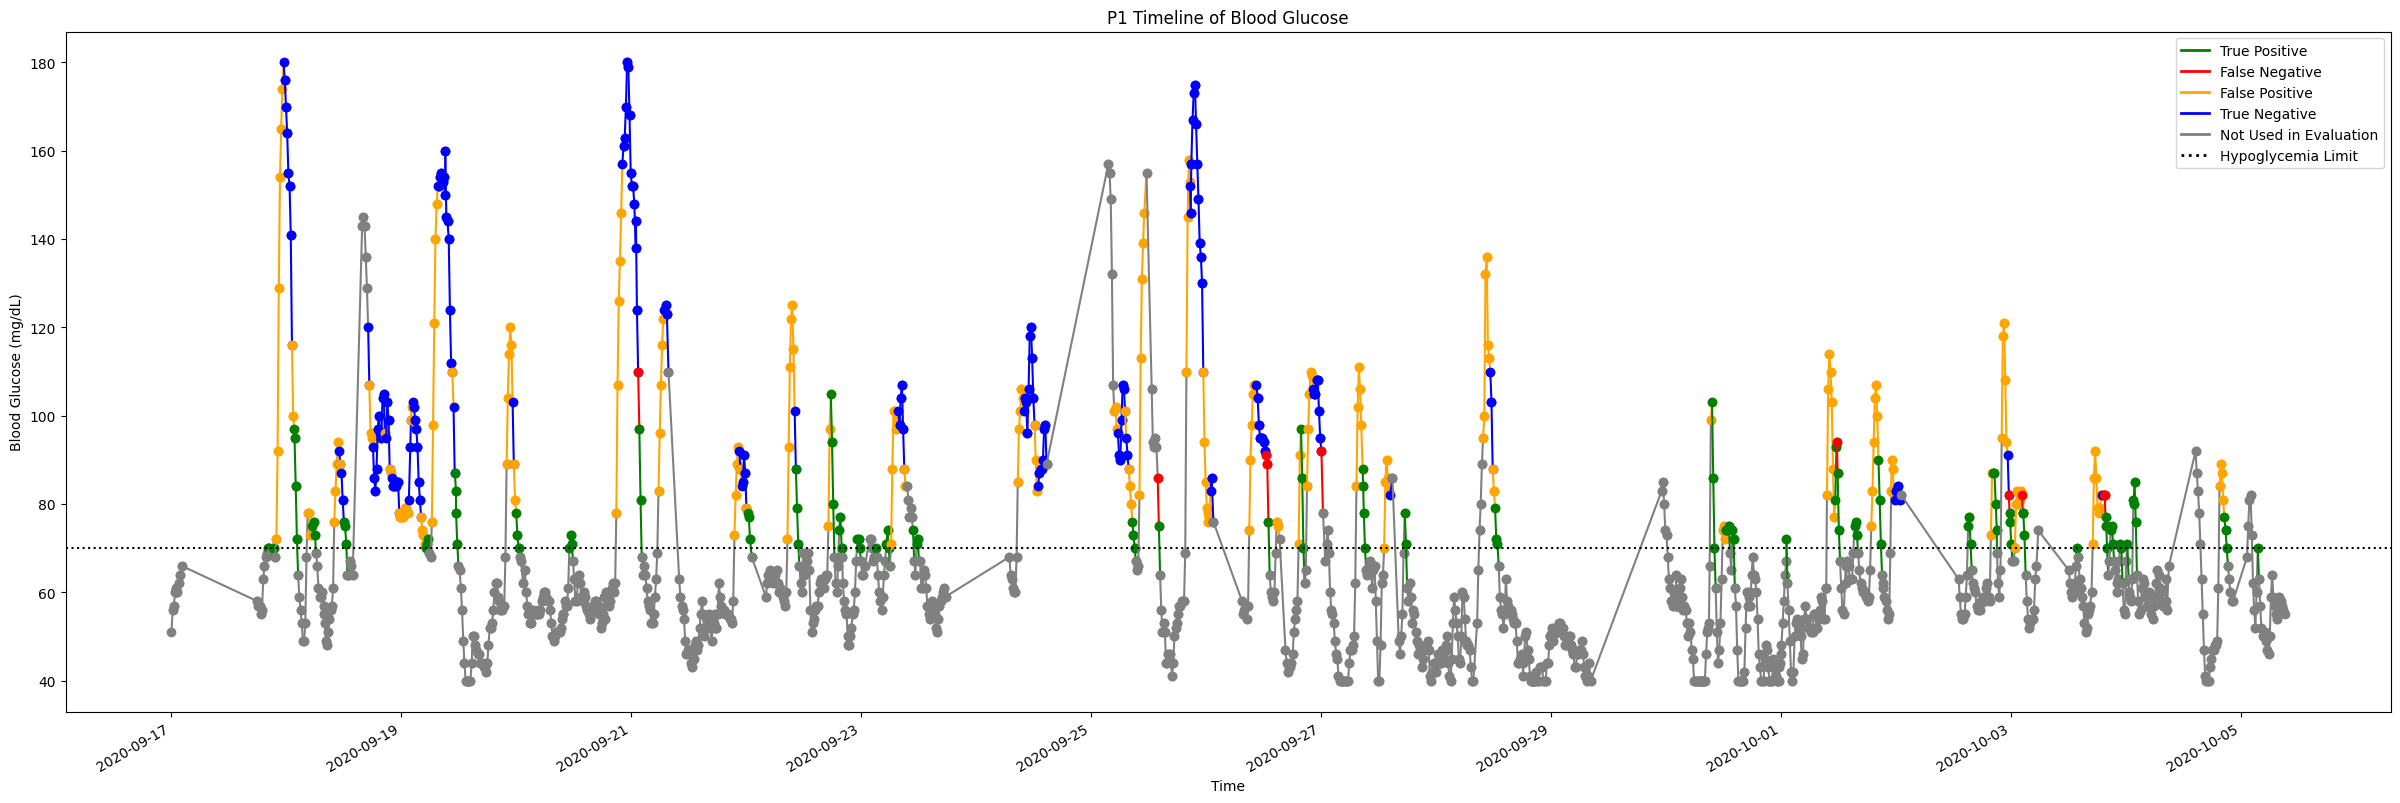

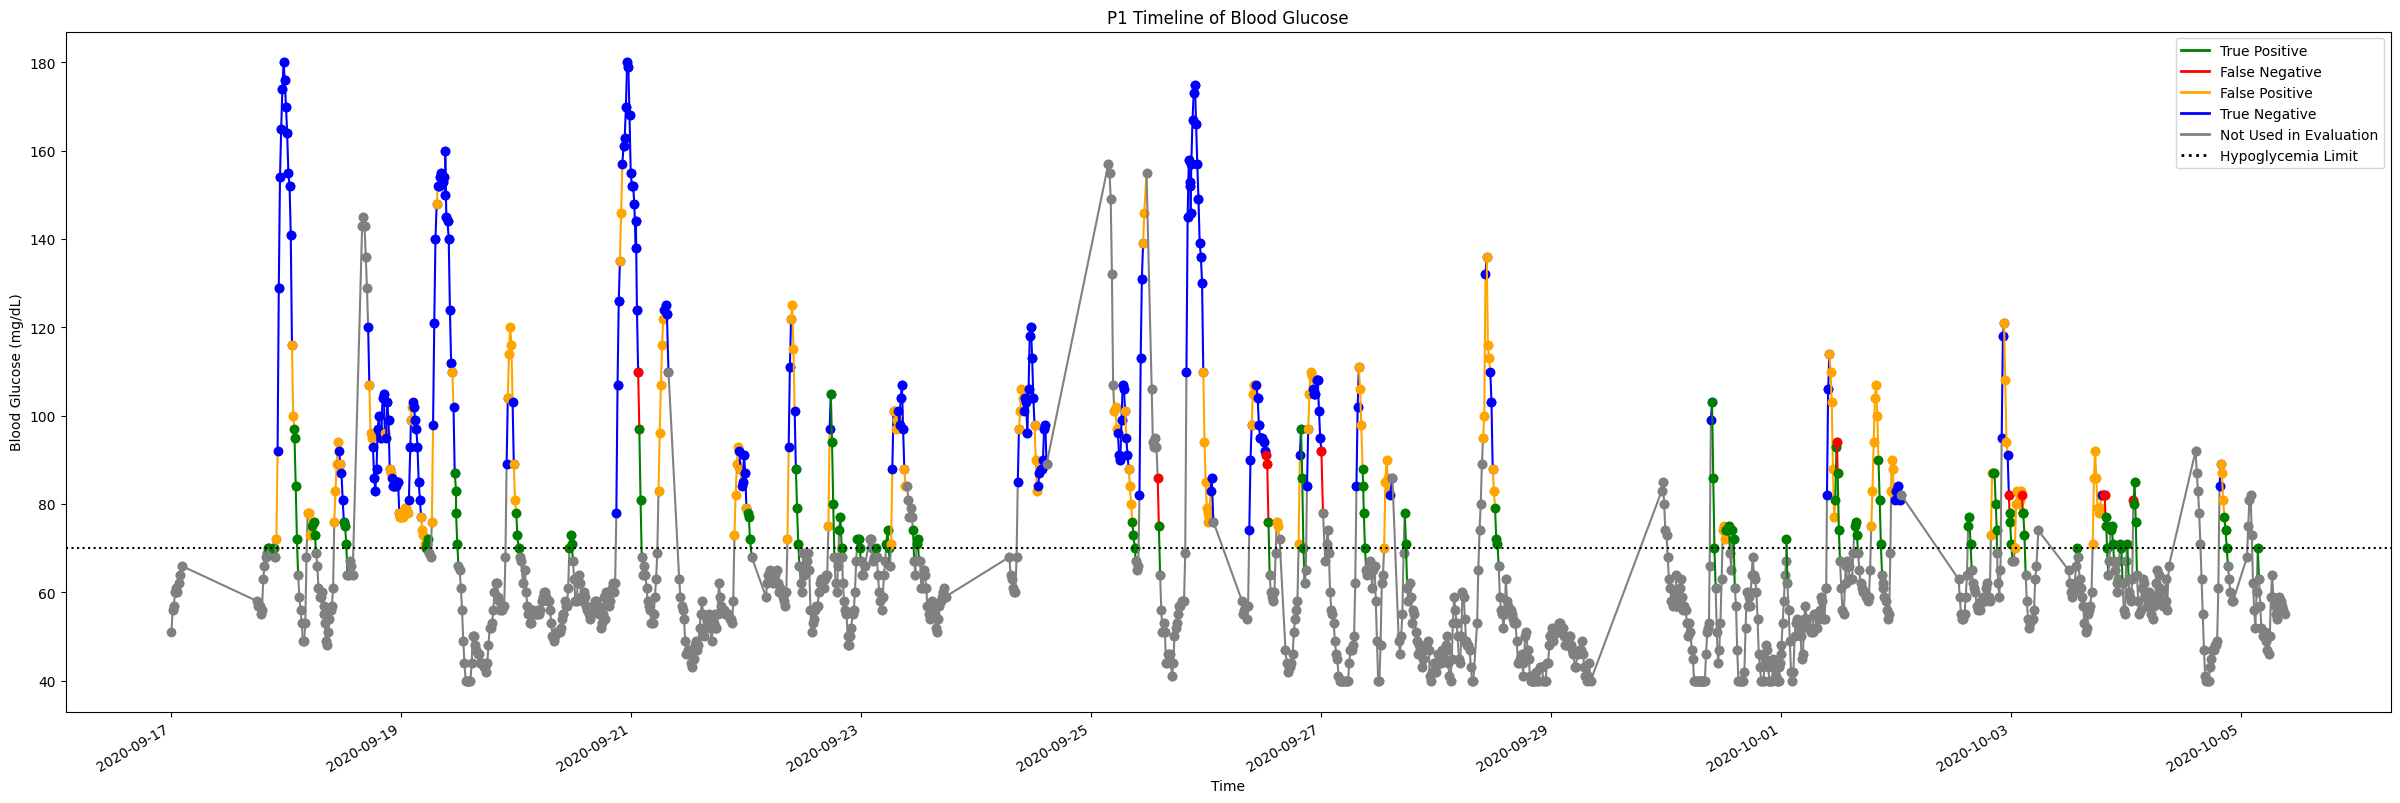

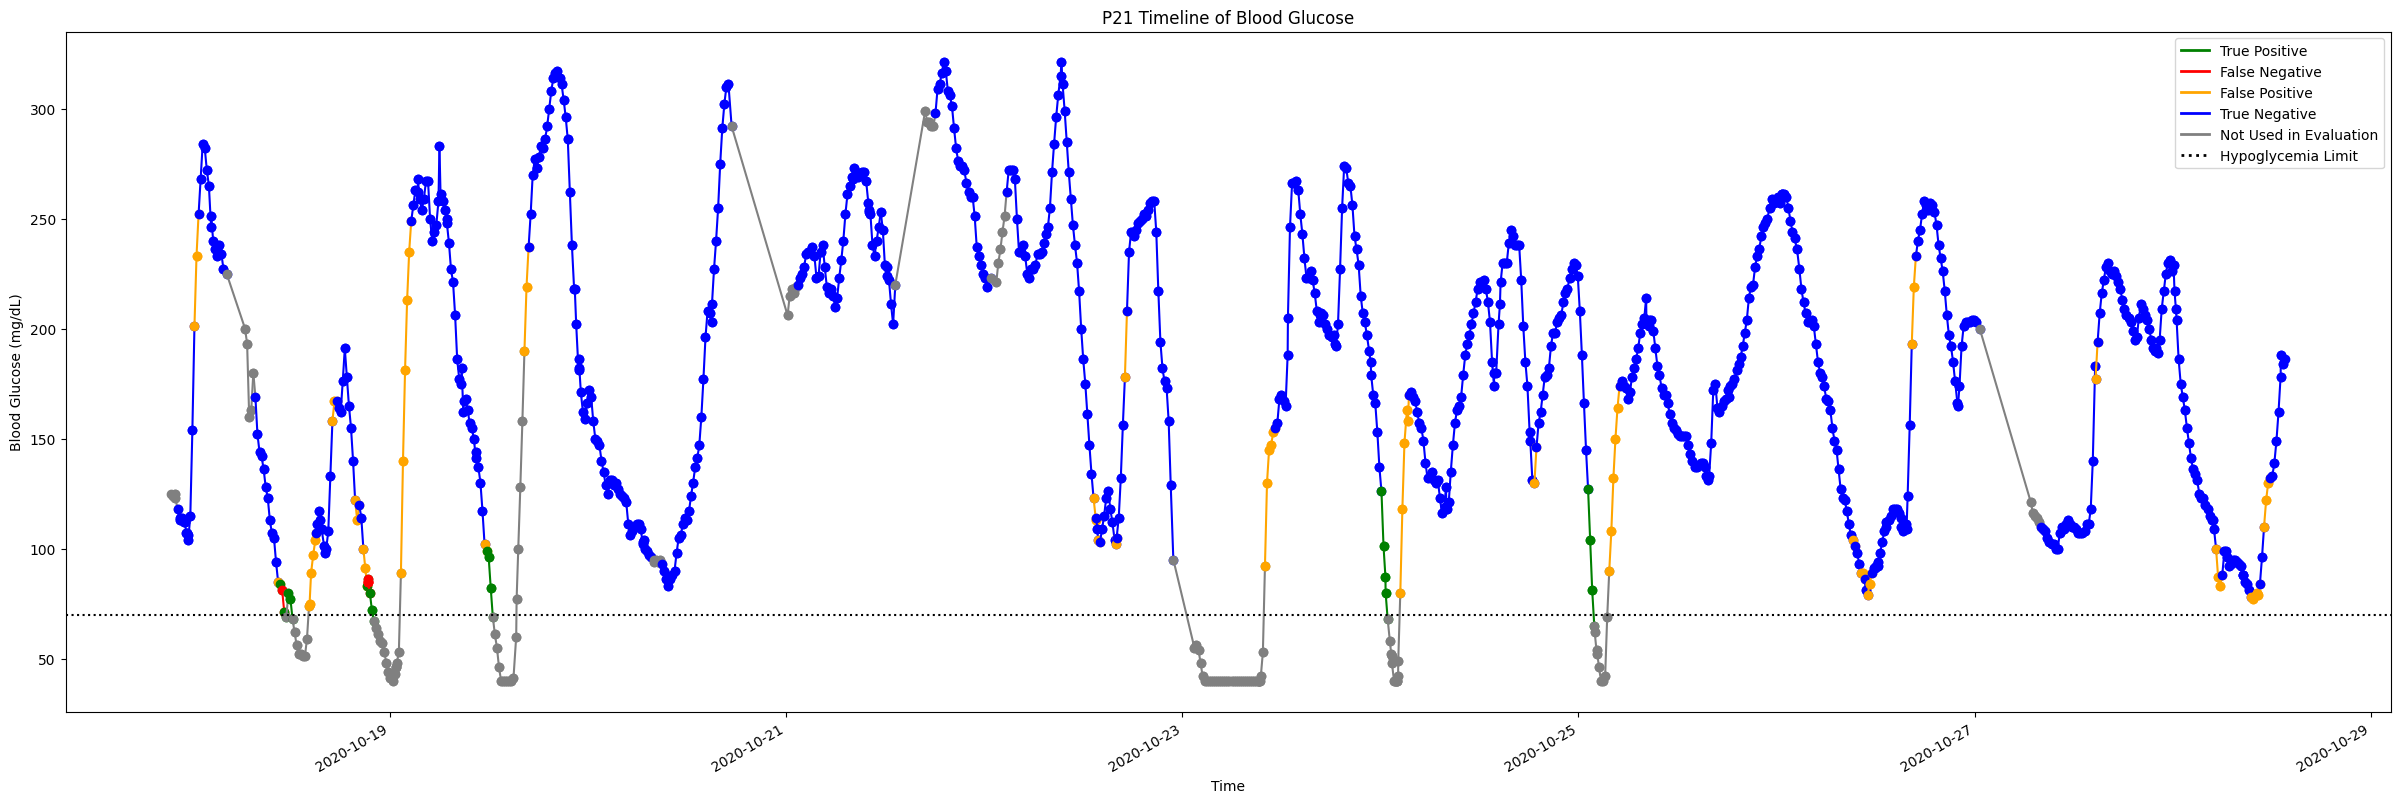

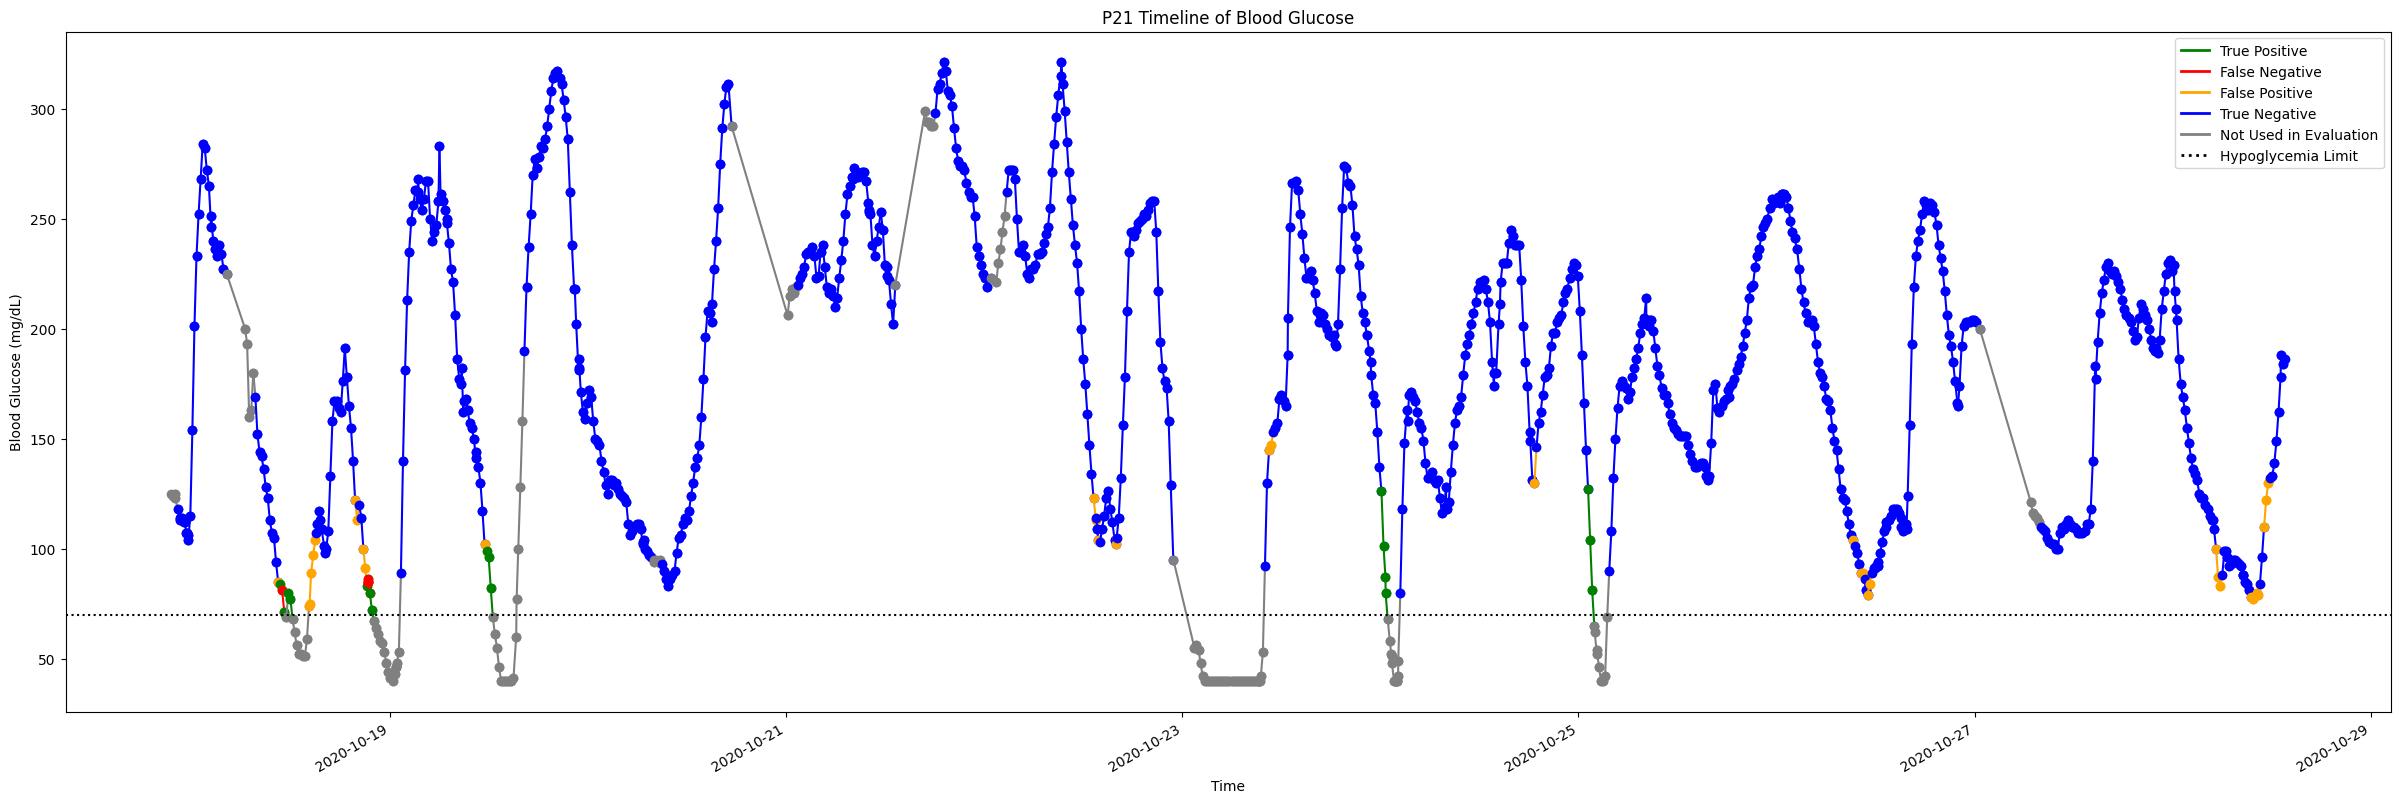

In [8]:
from utils.VisualizationUtils import draw_timeline
from utils.PropertyNames import ColumnNames as Cols
from utils.PropertyNames import MethodOptions as Opts

from Benchmark import add_alerts, add_target_column

naive_threshold = 15

params = {
    "k": 6,
    "risky_chars": {0, 1},
    "risk_threshold": 0.2,
    "prune": True,
    "prune_method": Opts.adaptive,
    "prune_threshold": 1,
    "weight_thresholds": [1, 4, 10],
    "value_ranges": [(0, 2), (2, 3), (3, float('inf'))],
    "max_steps": 6,
}

# Pick an alert model here
alert_to_plot = Cols.combined_alert_and

patient_data_with_alerts = add_target_column(patient_data)
patient_data_with_alerts = add_alerts(patient_data_with_alerts, naive_threshold, **params)

excluded = patients.copy().tolist()

for p in ["P1",'P21']:
    draw_timeline(
        patient_data_with_alerts[patient_data_with_alerts[Cols.patient] == p].sort_values(Cols.date, ascending=True), p,
        Cols.prob_alert, include_already_dangerous=False)
    draw_timeline(
        patient_data_with_alerts[patient_data_with_alerts[Cols.patient] == p].sort_values(Cols.date, ascending=True), p,
        Cols.combined_alert_and, include_already_dangerous=False)


Regenerate our model with alert this time for further analysis

In [9]:
from utils.PropertyNames import ColumnNames as Cols
from utils.PropertyNames import MethodOptions as Opts

from Benchmark import add_alerts, add_target_column

naive_threshold = 15

params = {
    "k": 6,
    "risky_chars": {0, 1},
    "risk_threshold": 0.2,
    "prune": True,
    "prune_method": Opts.adaptive,
    "prune_threshold": 1,
    "weight_thresholds": [1, 4, 10],
    "value_ranges": [(0, 2), (2, 3), (3, float('inf'))],
    "max_steps": 6,
}

patient_data_with_alerts = add_target_column(patient_data)
patient_data_with_alerts = add_alerts(patient_data_with_alerts, naive_threshold, **params)


See missed warnings count

In [10]:
import numpy as np

no_warning = 0
gave_warning = 0

for p in patients:
    df = patient_data[patient_data[Cols.patient] == p].copy()
    df = df.dropna(
        subset=[Cols.target, Cols.naive_alert, Cols.prob_alert, Cols.combined_alert_and, Cols.combined_alert_or])
    crossed_70 = (df[Cols.value] < 70) & (df[Cols.value].shift(1) >= 70)
    alert_true = df[Cols.combined_alert_and].shift(1).astype(bool)
    target_true = df[Cols.target].shift(1).astype(bool)

    gave_warning += np.sum(crossed_70 & alert_true & target_true)
    no_warning += np.sum(crossed_70 & ~alert_true & target_true)

print('gave_warning:', gave_warning)
print('no_warning:', no_warning)
print(gave_warning / (gave_warning + no_warning))


0.9645390070921985


Calculate forecast times

In [11]:
from utils.VisualizationUtils import draw_histogram

time_diff_list = []

pdict = dict()

for p in patients:
    df = patient_data[patient_data[Cols.patient] == p].copy().sort_values(Cols.date, ascending=True).reset_index(
        drop=True)
    df = df.dropna(subset=[Cols.target, Cols.naive_alert, Cols.prob_alert, Cols.combined_alert_and,
                           Cols.combined_alert_or]).reset_index(drop=True)  # Reset index after dropna
    crossed_70 = (df[Cols.value] < 70) & (df[Cols.value].shift(1) >= 70)

    for i in range(1, len(df)):
        # Check if value crosses below 70
        if crossed_70[i]:
            start_time = df.loc[i, Cols.date]
            # Iterate backwards to find the earliest point where both alert and target are true
            for j in range(i - 2, -1, -1):
                # Ignore point if value goes under 70 again
                if df.loc[j, Cols.value] < 70:
                    break
                # Check if both target and alert are true
                elif bool(df.loc[1, Cols.combined_alert_and]) is False or bool(df.loc[1, Cols.target]):
                    end_time = df.loc[j, Cols.date]
                    time_diff = start_time - end_time
                    time_diff_list.append(time_diff)
                    if p not in pdict.keys():
                        pdict[p] = 1
                    else:
                        pdict[p] += 1
                    break  # Found the required point, no need to check further

# Convert list of timedelta objects to desired format (e.g., total seconds)
time_diff_seconds = [td.total_seconds() for td in time_diff_list]
time_diff_minutes = [td / 60 for td in time_diff_seconds]
time_diff_minutes = [x for x in time_diff_minutes if x <= 60]

print(len(pdict), pdict)
print(time_diff_minutes)


14 {'P24': 19, 'P19': 11, 'P13': 5, 'P16': 13, 'P1': 45, 'P21': 7, 'P11': 4, 'P18': 21, 'P10': 21, 'P8': 18, 'P20': 5, 'P17': 11, 'P26': 78, 'P9': 15}
[26.0, 30.0, 14.0, 24.0, 30.0, 5.0, 32.0, 30.0, 24.0, 10.0, 23.0, 30.0, 15.0, 18.0, 11.0, 30.0, 28.0, 30.0, 30.0, 19.0, 30.0, 30.0, 28.0, 30.0, 30.0, 30.0, 30.0, 30.0, 15.0, 30.0, 31.0, 30.0, 30.0, 30.0, 30.0, 29.0, 15.0, 7.0, 31.0, 30.0, 30.0, 30.0, 28.0, 33.0, 30.0, 30.0, 29.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 21.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 15.0, 30.0, 30.0, 28.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 16.0, 30.0, 15.0, 15.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 21.0, 30.0, 30.0, 30.0, 31.0, 30.0, 30.0, 30.0, 20.0, 30.0, 31.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 29.0, 30.0, 30.0, 30.0, 30.0, 31.0, 30.0, 30.0, 25.0, 31.0, 30.0, 30.0, 30.0, 31.0, 32.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0

Draw Timeline of Forecasts

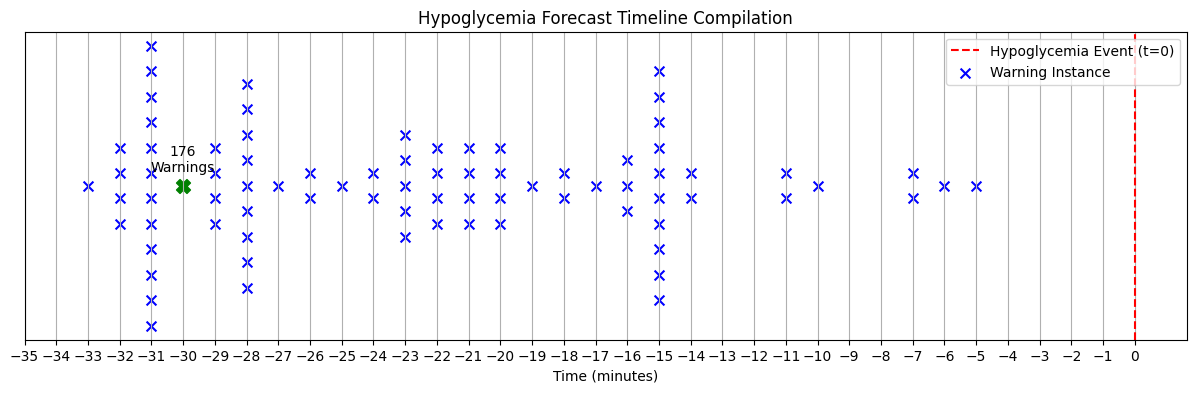

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

def draw_timeline(event_times, threshold=15):
    counter = Counter(event_times)

    # Sort events
    sorted_events = sorted(counter.items())

    # Vertical spacing between events at the same time
    vertical_step = 0.2

    # Create timeline plot
    plt.figure(figsize=(15, 4))
    plt.axvline(x=0, color='red', linestyle='--', label='Hypoglycemia Event (t=0)')  # Line at t=0
    first_x_plotted = False  # Flag to track whether the first 'x' marker has been plotted

    for time, count in sorted_events:
        mirror_time = -time  # Multiply by -1 to mirror the timeline
        if count > threshold:
            # If count exceeds threshold, plot a single special marker
            plt.scatter(mirror_time, 0, marker='X', s=100, color='green')
            plt.annotate(f'{count}\nWarnings', (mirror_time, 0), textcoords="offset points", xytext=(0,10), ha='center')  # Bold text
        else:
            # Calculate starting vertical offset for this time event to center it
            vertical_offset = -(count - 1) * vertical_step / 2
            for _ in range(count):
                plt.scatter(mirror_time, vertical_offset, marker='x', s=50, color='blue', label='Warning Instance' if not first_x_plotted else "")
                vertical_offset += vertical_step
                first_x_plotted = True

    plt.xlabel('Time (minutes)')
    plt.title('Hypoglycemia Forecast Timeline Compilation')
    plt.yticks([])  # Hide y-axis
    plt.xticks(range(-35, 1, 1))  # Set x-ticks
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Test function with sample data
draw_timeline(time_diff_minutes)


Draw ROC Curve

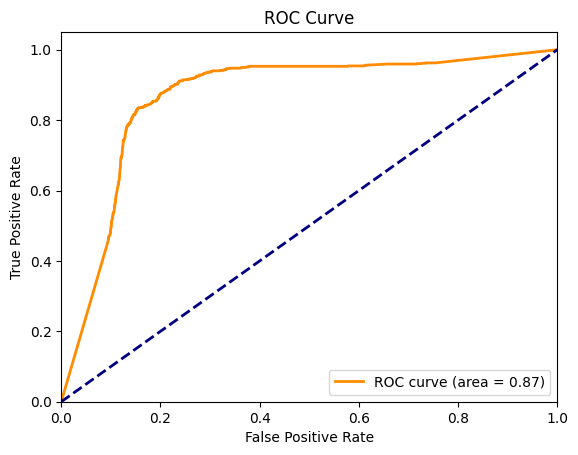

In [13]:
from sklearn.metrics import roc_curve, auc
import pickle

filtered_df = result_df[result_df[Cols.isDangerous] == False]

filtered_df = filtered_df[[Cols.combined_alert_and, Cols.target, "Probabilistic_Alert_Prob"]]

filtered_df = filtered_df.dropna()

y_true = filtered_df[Cols.target]
y_prob = filtered_df["Probabilistic_Alert_Prob"]


fpr, tpr, thresholds = roc_curve(list(y_true), list(y_prob))
roc_auc = auc(fpr, tpr)

data_to_save = {
    "roc_auc": roc_auc,
    "fpr": fpr,
    "tpr": tpr
}

# Saving the data to a binary file
with open("Data/roc_data.pkl", "wb") as file:
    pickle.dump(data_to_save, file)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  